<a href="https://colab.research.google.com/github/d-vf/P2PEnergyTrading/blob/main/implementation/Single_timestep_LP_DC_aprox_210724.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes:

On Gurobi
* Documentation on "heuristics", does not state what is actually doing
* does not know indicator functions or allows assignment
* more than 2000 variables (not the case, as number of variables is n Θ, n $t$ plus de "dummy" n) it is needed to set licence environment. If need pass it as parameter env.

On the Matching algo
* does not handle loops very well, so need to include a "dummy placeholder", otherwise gets "stuck" in a loop (when solving), to allow to interact within the loop
* it is need to desable presolve (also with loops), otherwise cannot even get interactions.

On Networks

- depending on the one used is need to check:
- MV connection is true (otherwise get orphans), if need just build from YBus from scratch
- pandapower uses also a reduced Ybus (that is a problem when it is needed same $n x n$ square matrices)

On Figures

- use kaleido to export as vector (pdf or svg)
fig.write_image("images/fig1.pdf")
fig.write_image("images/fig1.svg")
https://plotly.com/python/static-image-export/
- recall 300 dpi is standard for printing



## Data, Libraries, set-up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data")

In [3]:
!apt-get install -y graphviz libgraphviz-dev #data viz
!pip install pygraphviz diagrams # diagrams
!pip install pandapower["all"] #data
! pip install gurobipy #gurobi (MILP)
! pip install scipy #transform .m to .pp
!pip install pydot graphviz # for HG
! pip install plotly #cute plots
! pip install -U kaleido #to save png IO

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 

In [4]:
import gurobipy as gp
# Create an environment with your WLS license
#params = {'**********',
#"WLSSECRET":'**********',
#"LICENSEID":'**********',
#}

#env = gp.Env(params=params)

# Create the model within the Gurobi environment
#m = gp.Model(env=env)

## Reading from already calculated clusters

In [ ]:
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data")
if not os.path.exists("images"):
    os.mkdir("images")

In [5]:
import pandas as pd
cluster_medians_solar = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians_solar.csv', header=0, sep=',')
cluster_medians = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians.csv', header=0, sep=',')
cluster_medians_com = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians_com.csv', header=0, sep=',')

In [6]:
import plotly.graph_objects as go

cluster_medians_solar["Hour"] = list(range(24))

fig = go.Figure()

# Add traces for each cluster
fig.add_trace(go.Scatter(x=cluster_medians_solar["Hour"], y=cluster_medians_solar["Cluster_0"], mode='lines', name='Cluster_0', line=dict(width=4)))
fig.add_trace(go.Scatter(x=cluster_medians_solar["Hour"], y=cluster_medians_solar["Cluster_1"], mode='lines', name='Cluster_1', line=dict(width=4)))
fig.add_trace(go.Scatter(x=cluster_medians_solar["Hour"], y=cluster_medians_solar["Cluster_2"], mode='lines', name='Cluster_2', line=dict(width=4)))


# Add a horizontal line at y=0 on the x-axis
fig.add_shape(go.layout.Shape(
    type="line",
    x0=0,
    x1=23,
    y0=0,
    y1=0,
    line=dict(color="black", width=3)
))
# Update axes titles
fig.update_xaxes(title_text="Hour of the Day")
fig.update_yaxes(title_text="kWh")
fig.update_xaxes(range=[0, 23])
# Update legend and layout
fig.update_layout(
    title="Daily Clusters - Solar Generation",
    font=dict(family="Times New Roman", size=18),
    title_x=0.5,
    legend=dict(orientation="h", x=1, y=1.1, xanchor="right"),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray',zeroline=True),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

fig.write_image("images/dailyclusters_solar.pdf")
fig.show()

In [7]:
import plotly.graph_objects as go

cluster_medians["Hour"] = list(range(24))

fig = go.Figure()

# Add traces for each cluster
fig.add_trace(go.Scatter(x=cluster_medians["Hour"], y=cluster_medians["Cluster_0"], mode='lines', name='Cluster_0', line=dict(width=4)))
fig.add_trace(go.Scatter(x=cluster_medians["Hour"], y=cluster_medians["Cluster_1"], mode='lines', name='Cluster_1', line=dict(width=4)))
fig.add_trace(go.Scatter(x=cluster_medians["Hour"], y=cluster_medians["Cluster_2"], mode='lines', name='Cluster_2', line=dict(width=4)))


# Update axes titles
fig.update_xaxes(title_text="Hour of the Day")
fig.update_yaxes(title_text="kWh")

# Add a horizontal line at y=0 on the x-axis
fig.add_shape(go.layout.Shape(
    type="line",
    x0=0,
    x1=23,
    y0=0,
    y1=0,
    line=dict(color="black", width=1)))

# Update legend and layout
fig.update_layout(
    title="Daily Clusters - Loads Residencial",
    font=dict(family="Times New Roman", size=18),
    title_x=0.5,
    legend=dict(orientation="h", x=1, y=1.1, xanchor="right"),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray',zeroline=True),
    yaxis=dict(showgrid=True, gridcolor='lightgray'))

fig.write_image("images/dailyclusters_residencial.pdf")
fig.show()

In [8]:
cluster_medians_com["Hour"] = list(range(24))
#fig = px.line(cluster_medians_com, x="Hour", y=["Cluster_0", "Cluster_1"], title="Daily Clusters - Loads Commercial")
#fig.update_xaxes(title_text="Hour of the Day ")
#fig.update_yaxes(title_text="Cluster Values(kWh)")
#fig.update_layout(legend=dict(orientation="h", x=0.5, y=1.1))
#fig.show()

## Network

In [9]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting.plotly import vlevel_plotly
import plotly.io as pio


net = pn.create_cigre_network_lv()

#net = pp.networks.create_synthetic_voltage_control_lv_network(network_class='village_1')
net.name = "cigre network lv"
fig = vlevel_plotly(net)
#fig.update_layout(width=800, height=600, plot_bgcolor='white',
#                  font=dict(family='Computer Modern, serif', size=12, color='black'))

fig.update_layout(width=800, height=600, plot_bgcolor='white', showlegend=False)

# Show the plot
fig.show()

# Number of buses
n_buses = len(net.bus)

In [10]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix

# Create a graph from the network
graph = pp.topology.create_nxgraph(net)

# Remove all loads and generations
net.load.drop(net.load.index, inplace=True)
net.sgen.drop(net.sgen.index, inplace=True)
net.gen.drop(net.gen.index, inplace=True)

# Transpose the DataFrame
transposed_df = cluster_medians.T
# Take just the first row (hour 11 for now)
first_row = transposed_df.iloc[:, 11]
#Removing previous values
net.load.drop(net.load.index, inplace=True)

# Find extreme buses (logic is that loads and sgen will be here....)
extreme_buses = [node for node, degree in graph.degree() if degree == 1]

# Calculate 50% of the extreme buses
num_to_add = int(len(extreme_buses) * 0.5)

# Randomly select 50% of the extreme buses
#np.random.shuffle(extreme_buses)
#selected_buses = extreme_buses[:num_to_add]

selected_buses_odd = extreme_buses[1::2][:num_to_add]
selected_buses_even = extreme_buses[0::2][:num_to_add]
#selected_buses = selected_buses_odd[:num_to_add]

# set loads on these
for bus in selected_buses_odd:
    load = first_row.iloc[1]
    q_value = np.abs(load * np.tan(np.arccos(0.99)))
    pp.create_load(net, bus=bus, p_mw=load/1e3,q_mvar=q_value/1e3) #recall that values are in MW

#Removing previous values
net.sgen.drop(net.sgen.index, inplace=True)

# Transpose the DataFrame for solar data
transposed_df_solar = cluster_medians_solar.T

# Take just the first row (hour 11 for now)
first_row_solar = transposed_df_solar.iloc[:, 11]

# Add sgens to the selected buses using solar data
for bus in selected_buses_even:
    #solar_value = first_row_solar[1] #1st cluster
    solar_value = first_row_solar.iloc[1]
    q_value = np.abs(solar_value * np.tan(np.arccos(0.99)))
    pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_value/1e3) #recall that values are in MW

In [11]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,None,16,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
1,None,18,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
2,None,22,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
3,None,36,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
4,None,40,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
5,None,42,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye


## Calculate net surplus/deficit at each bus (generation - load)

In [12]:
import pandas as pd
import numpy as np

# Initialize dictionaries to track total traded quantities
load_traded = {node: 0 for node in net['load']['bus'].unique()}
gen_traded = {node: 0 for node in net['sgen']['bus'].unique()}

initial_gen_capacity = {node: capacity for node, capacity in zip(net['sgen']['bus'], net['sgen']['p_mw'])}
initial_load_demand = {node: demand for node, demand in zip(net['load']['bus'], net['load']['p_mw'])}

# Set fixed ask and bid prices for buyers (loads) and sellers (generators)
fixed_ask_price = 0.2  # Fixed price for buyers
fixed_bid_price = 0.05  # Fixed price for sellers

# Calculate net surplus/deficit at each bus (generation - load)
net_surplus_deficit = {node: gen - initial_load_demand.get(node, 0) for node, gen in initial_gen_capacity.items()}
net_surplus_deficit.update({node: -load for node, load in initial_load_demand.items() if node not in net_surplus_deficit})

# Generate buy orders for buses with a deficit
buy_orders = [{'node': node, 'price': fixed_ask_price, 'quantity': -deficit}
              for node, deficit in net_surplus_deficit.items() if deficit < 0]

# Generate sell orders for all buses with generation capacity
sell_orders = [{'node': node, 'price': fixed_bid_price, 'quantity': surplus}
               for node, surplus in net_surplus_deficit.items()]

# Convert orders to DataFrame and sort them
buy_orders_df = pd.DataFrame(buy_orders).sort_values(by='price')
sell_orders_df = pd.DataFrame(sell_orders).sort_values(by='price', ascending=False)


# Initialize lists for matches
buyer_matches = []
seller_matches = []

for buy_idx, buy in buy_orders_df.iterrows():
    if buy['quantity'] <= 0:
        continue

    for sell_idx, sell in sell_orders_df.iterrows():
        if sell['quantity'] <= 0:
            continue

        if buy['node'] != sell['node'] and buy['price'] >= sell['price']:
            traded_quantity = min(buy['quantity'], sell['quantity'])

            # Update quantities for both buyer and seller
            buy_orders_df.at[buy_idx, 'quantity'] -= traded_quantity
            sell_orders_df.at[sell_idx, 'quantity'] -= traded_quantity

            # Record the match for both the buyer and the seller
            buyer_matches.append((buy['node'], sell['node'], traded_quantity, sell['price']))
            seller_matches.append((sell['node'], buy['node'], traded_quantity, sell['price']))

            # Break the loop if the current seller has no more quantity to sell
            if sell_orders_df.at[sell_idx, 'quantity'] <= 0:
                break

            # Break the loop if the current buyer's demand is satisfied
            if buy_orders_df.at[buy_idx, 'quantity'] <= 0:
                break

# Print the matches for buyers
print("Matches for Buyers:", buyer_matches)

# Print the matches for sellers
print("Matches for Sellers:", seller_matches)

Matches for Buyers: [(16.0, 12.0, 0.0012150000000000002, 0.05), (18.0, 17.0, 0.0012150000000000002, 0.05), (22.0, 19.0, 0.0012150000000000002, 0.05), (36.0, 35.0, 0.0012150000000000002, 0.05), (40.0, 37.0, 0.0012150000000000002, 0.05), (42.0, 41.0, 0.0012150000000000002, 0.05)]
Matches for Sellers: [(12.0, 16.0, 0.0012150000000000002, 0.05), (17.0, 18.0, 0.0012150000000000002, 0.05), (19.0, 22.0, 0.0012150000000000002, 0.05), (35.0, 36.0, 0.0012150000000000002, 0.05), (37.0, 40.0, 0.0012150000000000002, 0.05), (41.0, 42.0, 0.0012150000000000002, 0.05)]


In [13]:
seller_matches

[(12.0, 16.0, 0.0012150000000000002, 0.05),
 (17.0, 18.0, 0.0012150000000000002, 0.05),
 (19.0, 22.0, 0.0012150000000000002, 0.05),
 (35.0, 36.0, 0.0012150000000000002, 0.05),
 (37.0, 40.0, 0.0012150000000000002, 0.05),
 (41.0, 42.0, 0.0012150000000000002, 0.05)]

In [14]:
buyer_matches

[(16.0, 12.0, 0.0012150000000000002, 0.05),
 (18.0, 17.0, 0.0012150000000000002, 0.05),
 (22.0, 19.0, 0.0012150000000000002, 0.05),
 (36.0, 35.0, 0.0012150000000000002, 0.05),
 (40.0, 37.0, 0.0012150000000000002, 0.05),
 (42.0, 41.0, 0.0012150000000000002, 0.05)]

# Testing extreme cases

In [15]:
extreme_added_flow = [(a, b, c * 100, d) for a, b, c, d in seller_matches]
extreme_added_flow

[(12.0, 16.0, 0.12150000000000001, 0.05),
 (17.0, 18.0, 0.12150000000000001, 0.05),
 (19.0, 22.0, 0.12150000000000001, 0.05),
 (35.0, 36.0, 0.12150000000000001, 0.05),
 (37.0, 40.0, 0.12150000000000001, 0.05),
 (41.0, 42.0, 0.12150000000000001, 0.05)]

# Network state without P2P

In [16]:
# Aggregate quantities for each buyer and seller from the matches

# Initialize seller_quantities dictionary
buyer_quantities = {}
for buy in buyer_matches:
    buyer = buy[0]
    quantity = buy[2]
    buyer_quantities[buyer] = buyer_quantities.get(buyer, 0) + quantity

# Initialize seller_quantities dictionary
seller_quantities = {}
for sell in seller_matches:
    seller = sell[0]
    quantity = sell[2]
    seller_quantities[seller] = seller_quantities.get(seller, 0) + quantity

# Reduce net.load demand by the quantities bought
for node, quantity_bought in buyer_quantities.items():
    net.load.loc[net.load.bus == node, 'p_mw'] = np.maximum(net.load.loc[net.load.bus == node, 'p_mw'] - quantity_bought, 0)

# Reduce net.sgen capacity by the quantities sold
for node, quantity_sold in seller_quantities.items():
    net.sgen.loc[net.sgen.bus == node, 'p_mw'] = np.maximum(net.sgen.loc[net.sgen.bus == node, 'p_mw'] - quantity_sold, 0)


In [17]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,None,16,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
1,None,18,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
2,None,22,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
3,None,36,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
4,None,40,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
5,None,42,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye


# Capacity (adjacency matrix)

In [18]:
import numpy as np
import pandas as pd
import math


net_N = pn.create_cigre_network_lv()

#net_N = pp.networks.create_synthetic_voltage_control_lv_network(network_class='village_1')

# Remove all loads and generations to start with 1
net_N.load.drop(net_N.load.index, inplace=True)
net_N.sgen.drop(net_N.sgen.index, inplace=True)
net_N.gen.drop(net_N.gen.index, inplace=True)

# Run the power flow
pp.rundcpp(net_N ) #DC

# Initialize an empty adjacency matrix
n_buses = len(net_N.bus)
adj_matrix = np.zeros((n_buses, n_buses))

# Assume a default angle of 30 degrees in radians
delta_rad = math.radians(30)

# Loop over lines to populate adjacency matrix
for i, line in net_N.line.iterrows():
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)
    reactance = line.x_ohm_per_km

    v_from = net_N.res_bus.vm_pu.loc[from_bus] * net_N.bus.vn_kv.loc[from_bus]
    v_to = net_N.res_bus.vm_pu.loc[to_bus] * net_N.bus.vn_kv.loc[to_bus]

    p_capacity = (v_from * v_to / reactance) * np.sin(delta_rad)

    adj_matrix[from_bus, to_bus] = p_capacity
    adj_matrix[to_bus, from_bus] = p_capacity

# Loop over transformers
for i, trafo in net_N.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)
    sn_mva = trafo.sn_mva

    adj_matrix[hv_bus, lv_bus] = sn_mva
    adj_matrix[lv_bus, hv_bus] = sn_mva


# Loop over external grid connections
for i, eg in net_N.ext_grid.iterrows():
    bus = int(eg.bus)
    p_mw = eg.vm_pu * net_N.bus.vn_kv.loc[bus]

    if bus != 0:
        adj_matrix[0, bus] = p_mw
        adj_matrix[bus, 0] = p_mw

# Loop over switches
for i, switch in net_N.switch.iterrows():
    bus = int(switch.bus)
    element = int(switch.element)

    if switch.closed:
        if switch.et == 'l':  # Line switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 't':  # Transformer switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 'b':  # Bus switch
            P_capacity_switch = 0  # Set to zero or use your custom logic
    else:
        P_capacity_switch = 0  # Open switch

    adj_matrix[bus, element] = P_capacity_switch
    adj_matrix[element, bus] = P_capacity_switch

ext_grid_bus = net_N.ext_grid.bus.values[0]
s_sc_max_mva = net_N.ext_grid.s_sc_max_mva.values[0]  # Assuming this is the capacity for ext_grid , if bus 80 need to comment this line
#s_sc_max_mva = 0

# Connect ext_grid to the transformers using capacity values
for i, hv_bus in enumerate(net_N.trafo.hv_bus.values):
    trafo_capacity = net_N.trafo.sn_mva.values[i]
    adj_matrix[ext_grid_bus, hv_bus] = min(s_sc_max_mva, trafo_capacity)
    adj_matrix[hv_bus, ext_grid_bus] = min(s_sc_max_mva, trafo_capacity)


# Convert to DataFrame
adj_matrix_df = pd.DataFrame(adj_matrix)
adj_matrix_array = adj_matrix_df.to_numpy()
adj_matrix.shape

(44, 44)

In [19]:
adj_matrix.shape

(44, 44)

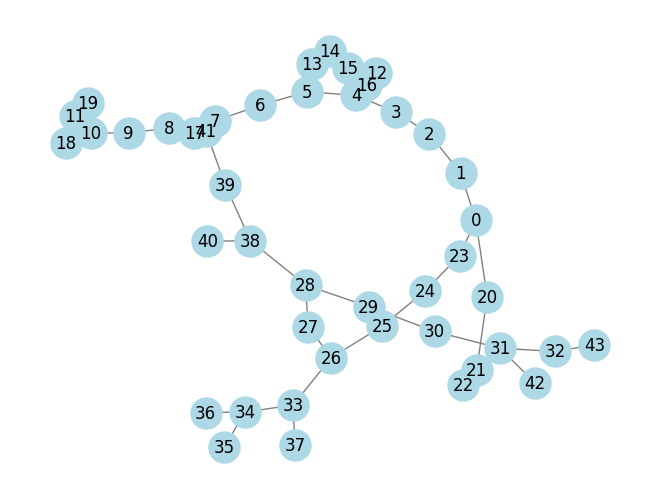

In [20]:
import networkx as nx

from matplotlib import pyplot as plt

# Create graph
G = nx.Graph(adj_matrix_array)

# Plot graph
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.show()

In [21]:
import pandapower as pp
import pandapower.networks as pn
import networkx as nx
import plotly.graph_objs as go
import plotly.io as pio
from networkx.drawing.nx_agraph import graphviz_layout
import kaleido

# Create graph
G = nx.Graph(adj_matrix_array)

# Extract the edges from the pandapower graph
edges_from_graph = list(G.edges())

# Extract the edges
edges_from_lines = list(net.line[['from_bus', 'to_bus']].itertuples(index=False))
edges_from_trafos = list(net.trafo[['hv_bus', 'lv_bus']].itertuples(index=False))
edges_from_switches = [(switch.bus, switch.element) for switch in net.switch[net.switch.closed].itertuples(index=False)]


# Create a new directed graph (DiGraph)
G = nx.DiGraph()

# Add the edges from lines and trafos to make it hierarchical
G.add_edges_from(edges_from_lines)
G.add_edges_from(edges_from_trafos)
G.add_edges_from(edges_from_switches)

# Modify node colors

# Remove selected buses from extreme_buses (this was calculate before to assign node, where loads to all with degree less than 1, then 50% get sgen)
extreme_buses_1 = [bus_id for bus_id in extreme_buses if bus_id not in selected_buses_odd]

# Create a dictionary to specify colors for the nodes
node_colors = {node: 'red' if node == 0 else 'green' if node in extreme_buses_1 else 'orange' if node in selected_buses_odd else 'grey' for node in net.bus.index}

# edge colors
edge_colors = {
    (0, 1): 'red',
    (0, 2): 'black',
}

# Get the layout of the graph
pos = graphviz_layout(G, prog="dot")

# Manually adjust the positions of bus 0 and bus 1, 23 to create a vertical alignment
#pos[0] = (549, 1300)
pos[0] = (333, 810)
pos[1] = (333, 810)
pos[23] = (333, 810)

fig = go.Figure()

# Loop through nodes and add them to the plot, set showlegend to False
for node in G.nodes:
    x, y = pos[node]
    color = node_colors.get(node, 'grey')
    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers',
                             marker=dict(size=10, color=color),
                             text=str(node), showlegend=False))

# Loop through edges and add them to the plot, set showlegend to False
for lv_bus, hv_bus in G.edges:
    x1, y1 = pos[lv_bus]
    x2, y2 = pos[hv_bus]
    color = edge_colors.get((lv_bus, hv_bus), 'black')
    fig.add_trace(go.Scatter(x=[x1, x2], y=[y1, y2], mode='lines',
                             line=dict(width=2, color=color), showlegend=False))
# Add legend with colors
legend_colors = {
    'Bus 0 (Slack)': 'red',
    'Consumers': 'green',
    'Prosumers': 'orange',
    'iddle': 'grey'
}

# legend with colors, attribute set to True
for label, color in legend_colors.items():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(size=10, color=color),
                             name=label, showlegend=True))


#layout
fig.update_layout(width=800, height=600, plot_bgcolor='white',
                  showlegend=True, legend=dict(orientation='h', x=0, y=1.1),
                  xaxis_visible=False, yaxis_visible=False,
                  font=dict(
                      family="'CMU Serif', serif",  # This is a font resembles LaTeX font
                      size=18,
                      color="black"
    ))

fig.update_yaxes(scaleanchor='x', scaleratio=0.5)


# Show the plot
fig.show()

# Save the figure with high resolution
fig.write_image("images/network_44_WB.pdf", width=800, height=600, scale=2)
#fig.write_image("images/network_80_WB.pdf", width=800, height=600, scale=2)

## Ybus

In [22]:
import numpy as np

# Initialize Ybus as a zeros matrix
Ybus = np.zeros((n_buses,n_buses), dtype=complex)

# Iterate over lines in the network
for _, line in net.line.iterrows():
    # Get the from and to buses
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)

    # Calculate the line admittance
    z = complex(line.r_ohm_per_km, line.x_ohm_per_km)  # r and x are given per km
    y = 1 / z

    # Populate the Ybus matrix
    Ybus[from_bus][from_bus] += y
    Ybus[to_bus][to_bus] += y
    Ybus[from_bus][to_bus] -= y
    Ybus[to_bus][from_bus] -= y

# Include switches (assumed open)
for _, switch in net.switch.iterrows():
    bus = int(switch.bus)
    Ybus[bus][bus] += 1e-6  # Small admittance to represent open switch

# Include external grid (slack bus)
slack_bus = 0
Ybus[slack_bus][slack_bus] += 1e6  # Large admittance to represent external grid

# Include transformers (equivalent pi-model)
for _, trafo in net.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)


    # Manually specify transformer parameters in per unit values
    vk_percent = trafo.vk_percent
    vkr_percent = trafo.vkr_percent

    # Calculate series and shunt admittances
    z_series = complex(0, vkr_percent / 100 * vk_percent / 100)  # Assuming vk_percent and vkr_percent are given in per unit
    y_series = 1 / z_series

    # Populate the Ybus matrix
    Ybus[hv_bus][hv_bus] += y_series
    Ybus[lv_bus][lv_bus] += y_series
    Ybus[hv_bus][lv_bus] -= y_series
    Ybus[lv_bus][hv_bus] -= y_series

print(Ybus)

[[1.00000000e+06+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ... 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00-2.42535603e+03j
  0.00000000e+00+2.42535603e+03j ... 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+2.42535603e+03j
  4.88448495e+00-2.42786461e+03j ... 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 ...
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ... 4.82598575e-01-7.99983655e-02j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ... 0.00000000e+00+0.00000000e+00j
  4.82598575e-01-7.99983655e-02j 0.00000000e+00+0.00000000e+00j]
 [0.000000

## Fixing Ybus

In [23]:
from pandapower.pypower.makeYbus import makeYbus

net_N["_ppc"]['internal']['Ybus']

orphaned_buses = set(net_N.bus.index) - set(net_N.line.from_bus) - set(net_N.line.to_bus) - set(net_N.trafo.hv_bus) - set(net_N.trafo.lv_bus)
if orphaned_buses:
    print(f"Orphaned buses detected: {orphaned_buses}")

print(net_N.ext_grid)

connected_lines = net_N.line[(net_N.line.from_bus == 0) | (net_N.line.to_bus == 0)]
print(connected_lines)

connected_trafos = net_N.trafo[(net_N.trafo.hv_bus == 0) | (net_N.trafo.lv_bus == 0)]
print(connected_trafos)

pp.create_ext_grid(net_N, bus=0, vm_pu=1.0, name="Grid Connection")
bus_hv = 0  # This is the bus where the external grid is connected.
#bus_lv = pp.create_bus(net, vn_kv=20.0, name="LV Bus")
#pp.create_transformer(net, hv_bus=bus_hv, lv_bus=bus_lv, std_type="25 MVA 110/20 kV", name="T1")


Ybus1, Yf, Yt = makeYbus(net_N._ppc['baseMVA'], net_N._ppc['bus'], net_N._ppc['branch'])
Ybus_dense_check = Ybus1.todense()
print(Ybus_dense_check.shape)

Orphaned buses detected: {0}
   name  bus  vm_pu  va_degree  slack_weight  in_service  s_sc_max_mva  \
0  None    0    1.0        0.0           1.0        True         100.0   

   s_sc_min_mva  rx_min  rx_max  
0         100.0     1.0     1.0  
Empty DataFrame
Columns: [name, std_type, from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, g_us_per_km, max_i_ka, df, parallel, type, in_service]
Index: []
Empty DataFrame
Columns: [name, std_type, hv_bus, lv_bus, sn_mva, vn_hv_kv, vn_lv_kv, vk_percent, vkr_percent, pfe_kw, i0_percent, shift_degree, tap_side, tap_neutral, tap_min, tap_max, tap_step_percent, tap_step_degree, tap_pos, tap_phase_shifter, parallel, df, in_service]
Index: []
(44, 44)


# Gurobi

In [24]:
formatted_matches =  extreme_added_flow #seller_matches #

In [25]:
seller_matches

[(12.0, 16.0, 0.0012150000000000002, 0.05),
 (17.0, 18.0, 0.0012150000000000002, 0.05),
 (19.0, 22.0, 0.0012150000000000002, 0.05),
 (35.0, 36.0, 0.0012150000000000002, 0.05),
 (37.0, 40.0, 0.0012150000000000002, 0.05),
 (41.0, 42.0, 0.0012150000000000002, 0.05)]

In [26]:
buyer_matches

[(16.0, 12.0, 0.0012150000000000002, 0.05),
 (18.0, 17.0, 0.0012150000000000002, 0.05),
 (22.0, 19.0, 0.0012150000000000002, 0.05),
 (36.0, 35.0, 0.0012150000000000002, 0.05),
 (40.0, 37.0, 0.0012150000000000002, 0.05),
 (42.0, 41.0, 0.0012150000000000002, 0.05)]

In [27]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,None,16,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
1,None,18,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
2,None,22,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
3,None,36,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
4,None,40,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
5,None,42,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye


In [28]:
from gurobipy import Model, GRB, quicksum, LinExpr
import numpy as np
import time

# Set Method
# -1 = automatic (default)
# 0 = primal simplex
# 1 = dual simplex
# 2 = barrier
# 3 = concurrent
# 4 = deterministic concurrent

# Create a new model
m = Model("p2p_optimization") # if more than 2000 variables need academic licence env=env
m.setParam("Method", 2) # Set Method to Interior Point (Barrier)
m.setParam('OutputFlag', 1)
m.setParam('Presolve', 0) #have to remove presolve otherwise will mess with updates and just remove all from the start

B = np.imag(Ybus)  # Susceptance matrix from the imaginary part of Ybus
n_buses = B.shape[0]
n_trades = len(formatted_matches)  # Number of P2P trades

# Define variables
theta = m.addVars(n_buses, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="theta")
slack_power = m.addVar(lb=-100, ub=100, name="slack_power")
x = m.addVars(len(formatted_matches), lb=0, ub=1, name="trade_vars")


slack_bus_index = 0  # Define bus 0 as the slack bus
total_power_mismatch = 0
total_demand = 0
total_gen = 0

for i in range(n_buses):
    sgen_indices = [t for t in net.sgen.index if net.sgen.at[t, 'bus'] == i]
    load_indices = [t for t in net.load.index if net.load.at[t, 'bus'] == i]

    generation_i = quicksum(net.sgen.at[t, 'p_mw'] for t in sgen_indices)
    demand_i = quicksum(net.load.at[t, 'p_mw'] for t in load_indices)

    # Adjust generation and demand based on P2P trades (adjustment plus mapping)
    for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
        if source_bus == i:
            generation_i += x[t] * quantity
        if dest_bus == i:
            demand_i += x[t] * quantity

    net_power_injection = generation_i - demand_i
    #total_power_mismatch += net_power_injection
    total_demand += demand_i  # Increment total demand
    total_gen += generation_i  # Increment total mismatch

    power_flow_in_i = quicksum(B[i, j] * (theta[i] - theta[j]) for j in range(n_buses) if j != i)

    # Apply power balance constraint for each bus
    if i != slack_bus_index:
      relax_var = m.addVar(name="dummy placeholder")
      m.addConstr(net_power_injection == power_flow_in_i - relax_var, name=f"net_power_balance_{i}")

    if i == slack_bus_index:
        # Update the mismatch specifically for the slack bus
        total_power_mismatch += net_power_injection
    else:
        # Update total mismatch for all other buses
        total_power_mismatch += net_power_injection

m.addConstr(slack_power == total_power_mismatch, name="slack_power_balance")

# Reference Bus Constraint
m.addConstr(theta[slack_bus_index] == 0)

# Angle difference constraints
# Power flow constraints
max_angle_diff = np.pi / 6  # 30 degrees
for i in range(n_buses):
    for j in range(n_buses):
        if i != j and B[i, j] > 0: #connection between buses i and j
            power_flow = B[i, j] * (theta[i] - theta[j])
            m.addConstr(power_flow <= adj_matrix[i, j], name=f"P_flow_max_{i}_{j}")
            m.addConstr(power_flow >= -adj_matrix[i, j], name=f"P_flow_min_{i}_{j}")
            m.addConstr(theta[i] - theta[j] <= max_angle_diff, name=f"angle_diff_max_{i}_{j}")
            m.addConstr(theta[i] - theta[j] >= -max_angle_diff, name=f"angle_diff_min_{i}_{j}")

#gurobi does not work with abs, so need to set 2 constraints

# list to store the trade quantities
trade_quantities = [quantity for _, _, quantity, _ in formatted_matches]
objective = quicksum(trade_quantities[t] * x[t] for t in range(len(formatted_matches)))

# Set the objective function in the model
m.setObjective(objective, GRB.MAXIMIZE)

# Callback function definition
def data_cb(model, where):
    if where == GRB.Callback.BARRIER:
        cur_obj = model.cbGet(GRB.Callback.BARRIER_PRIMOBJ)
        runtime = time.time() - model._start
        model._data.append([runtime, cur_obj])

m._obj = None
m._bd = None
m._data = []
m._start = time.time()

m.optimize(data_cb)

# Output
if m.status == GRB.OPTIMAL or m.status == GRB.SUBOPTIMAL:

    print("Optimal solution found:")

    # Print theta values for each bus
    for i in range(n_buses):
        print(f"Bus {i} Theta: {theta[i].X:.6f}")

    # Print trade execution levels (x[t]) along with associated quantities
    for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
        executed_quantity = x[t].X * quantity
        print(f"Trade {t}: Execution level (x[{t}]): {x[t].X:.6f}, Quantity: {quantity}, Executed Quantity: {executed_quantity:.6f}")

    # Print slack power
    print(f"Slack Power: {slack_power.X:.6f}")

    # After optimization, retrieve the objective value
    objective_value = m.ObjVal

    # Calculate total demand value
    total_demand_value = total_demand.getValue()

    # Sum the objective value and total demand value
    total_sum = objective_value + total_demand_value

    print(f"Total load across all buses: {total_demand_value:.6f}")

if m.status == GRB.INF_OR_UNBD:
    print('Model is infeasible or unbounded')
elif m.status == GRB.INFEASIBLE:
    m.computeIIS()
    m.write("model.ilp")
    # Check the values of the slack/surplus variables
    for c in m.getConstrs():
        if c.IISConstr:
            print(f"Constraint {c.constrName} is part of the IIS.")
    for v in m.getVars():
        if v.VarName.startswith('ArtN_') or v.VarName.startswith('ArtS_'):
            if v.X > 1e-5:  # A threshold to determine if the slack variable is significant
                print(f"Constraint {v.VarName} was relaxed by {v.X}")
    # Perform a feasibility relaxation to identify which constraints are problematic
    m.feasRelaxS(0, False, False, True)
    m.optimize()
        # Print trade execution levels (x[t]) along with associated quantities
        # Print theta values for each bus

    objective_value = m.ObjVal

    print(f"Total P2P traded: {objective_value:.6f}")

    # Calculate total demand value
    total_demand_value = total_demand.getValue()

    # Sum the objective value and total demand value
    total_sum = objective_value + total_demand_value

    print(f"Total invariable load across all buses: {total_sum:.6f}")

    for i in range(n_buses):
        print(f"Bus {i} Theta: {theta[i].X:.6f}")

        # Print P variable value for each bus
    for i in range(n_buses):
       print(f"Bus {i} P: {relax_var[i].X:.6f}")
    for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
        executed_quantity = x[t].X * quantity
        print(f"Trade {t}: Execution level (x[{t}]): {x[t].X:.6f}, Quantity: {quantity}, Executed Quantity: {executed_quantity:.6f}")

    print('Model is infeasible')
elif m.status == GRB.UNBOUNDED:
    print('Model is unbounded')
else:
    print(f'Optimization was stopped with status {m.status}')

Restricted license - for non-production use only - expires 2025-11-24
Set parameter Method to value 2
Set parameter Presolve to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 365 rows, 94 columns and 820 nonzeros
Model fingerprint: 0x906d16f1
Coefficient statistics:
  Matrix range     [8e-02, 2e+03]
  Objective range  [1e-01, 1e-01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e-03, 1e+00]

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 43
 AA' NZ     : 5.612e+03
 Factor NZ  : 6.264e+03
 Factor Ops : 1.205e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.66249794e+01  7.47548245e-01  1.23e+01 7.39e-01  5.14e+00   

In [29]:
from gurobipy import Model, GRB, quicksum, LinExpr
import numpy as np
import time

# Create a new model
m = Model("p2p_optimization") # if more than 2000 variables need academic licence env=env
m.setParam("Method", 2) # Set Method to Interior Point (Barrier)
m.setParam('OutputFlag', 1)
m.setParam('Presolve', 0) #have to remove presolve otherwise will mess with updates and just remove all from the start

B = np.imag(Ybus)  # Susceptance matrix from the imaginary part of Ybus
n_buses = B.shape[0]
n_trades = len(formatted_matches)  # Number of P2P trades

# Define variables
theta = m.addVars(n_buses, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="theta")
slack_power = m.addVar(lb=-100, ub=100, name="slack_power")
x = m.addVars(len(formatted_matches), lb=0, ub=1, name="trade_vars")

M = 1e7  # A large constant, Big M

slack_bus_index = 0  # Define bus 0 as the slack bus
total_power_mismatch = 0
total_demand = 0
total_gen = 0


for i in range(n_buses):
    sgen_indices = [t for t in net.sgen.index if net.sgen.at[t, 'bus'] == i]
    load_indices = [t for t in net.load.index if net.load.at[t, 'bus'] == i]

    generation_i = quicksum(net.sgen.at[t, 'p_mw'] for t in sgen_indices)
    demand_i = quicksum(net.load.at[t, 'p_mw'] for t in load_indices)

    # Adjust generation and demand based on P2P trades (adjustment plus mapping)
    for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
        if source_bus == i:
            generation_i += x[t] * quantity
        if dest_bus == i:
            demand_i += x[t] * quantity

    net_power_injection = generation_i - demand_i
    total_power_mismatch += net_power_injection
    total_demand += demand_i  # Increment total demand
    total_gen += generation_i  # Increment total mismatch

    power_flow_in_i = quicksum(B[i, j] * (theta[i] - theta[j]) for j in range(n_buses) if j != i)

    # Conditional constraint adjustment with Big M explicity
    for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
        if source_bus == i:
            m.addConstr(net_power_injection + M * (1 - x[t]) >= power_flow_in_i, name=f"net_power_balance_active_{i}_{t}")
        elif dest_bus == i:
            m.addConstr(net_power_injection - M * (1 - x[t]) <= -power_flow_in_i, name=f"net_power_balance_inactive_{i}_{t}")

    # Apply power balance constraint for each bus
    if i != slack_bus_index:
      relax_var = m.addVar(name="dummy placeholder")
      m.addConstr(net_power_injection == power_flow_in_i - relax_var, name=f"net_power_balance_{i}")

    # For all buses, calculate the mismatch between generation (or net power injection) and power flow
    # Adjust total power mismatch accordingly
    if i == slack_bus_index:
        # For slack bus, calculate mismatch differently as it balances the total power in the system
        total_power_mismatch += (net_power_injection)
    else:
        # For non-slack buses, mismatches are implicitly handled but do not contribute directly to slack calculation
        pass


m.addConstr(slack_power == total_power_mismatch, name="slack_power_balance") #out of loop to get all acroos the system

# Reference Bus Constraint
m.addConstr(theta[slack_bus_index] == 0)

# Angle difference constraints
# Power flow constraints
max_angle_diff = np.pi / 6  # 30 degrees
for i in range(n_buses):
    for j in range(n_buses):
        if i != j and B[i, j] > 0: #connection between buses i and j
            power_flow = B[i, j] * (theta[i] - theta[j]) #power flow
            m.addConstr(power_flow <= adj_matrix[i, j], name=f"P_flow_max_{i}_{j}")
            m.addConstr(power_flow >= -adj_matrix[i, j], name=f"P_flow_min_{i}_{j}")
            m.addConstr(theta[i] - theta[j] <= max_angle_diff, name=f"angle_diff_max_{i}_{j}")
            m.addConstr(theta[i] - theta[j] >= -max_angle_diff, name=f"angle_diff_min_{i}_{j}")

#gurobi does not work with abs, so need to set 2 constraints

# list to store the trade quantities
trade_quantities = [quantity for _, _, quantity, _ in formatted_matches]
objective = quicksum(trade_quantities[t] * x[t] for t in range(len(formatted_matches)))

# Set the objective function in the model
m.setObjective(objective, GRB.MAXIMIZE)

# Callback function definition
def data_cb(model, where):
    if where == GRB.Callback.BARRIER:
        cur_obj = model.cbGet(GRB.Callback.BARRIER_PRIMOBJ)
        runtime = time.time() - model._start
        model._data.append([runtime, cur_obj])

m._obj = None
m._bd = None
m._data = []
m._start = time.time()

m.optimize(data_cb)

# Output
if m.status == GRB.OPTIMAL or m.status == GRB.SUBOPTIMAL:

    print("Optimal solution found:")

    # Print theta values for each bus
    for i in range(n_buses):
        print(f"Bus {i} Theta: {theta[i].X:.6f}")
        #print(f"Bus {i} P: {relax_var[i].X:.6f}")

    # Print trade execution levels (x[t]) along with associated quantities
    #total_executed_quantity = 0
    for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
        executed_quantity = x[t].X * quantity
        print(f"Trade {t}: Execution level (x[{t}]): {x[t].X:.6f}, Quantity: {quantity}, Executed Quantity: {executed_quantity:.6f}")
    #total_executed_quantity += executed_quantity
    # Print slack power
    print(f"Slack Power: {slack_power.X:.6f}")

    # After optimization, retrieve the objective value
    objective_value = m.ObjVal

    # Calculate total demand value
    total_demand_value = total_demand.getValue()

    # Sum the objective value and total demand value
    total_sum = objective_value + total_demand_value

    print(f"Total load across all buses: {total_demand_value:.6f}")

if m.status == GRB.INF_OR_UNBD:
    print('Model is infeasible or unbounded')
elif m.status == GRB.INFEASIBLE:
    m.computeIIS()
    m.write("model.ilp")
    # Check the values of the slack/surplus variables
    for c in m.getConstrs():
        if c.IISConstr:
            print(f"Constraint {c.constrName} is part of the IIS.")
    for v in m.getVars():
        if v.VarName.startswith('ArtN_') or v.VarName.startswith('ArtS_'):
            if v.X > 1e-5:  # A threshold to determine if the slack variable is significant
                print(f"Constraint {v.VarName} was relaxed by {v.X}")
    # Perform a feasibility relaxation to identify which constraints are problematic
    m.feasRelaxS(0, False, False, True)
    m.optimize()


    objective_value = m.ObjVal

    print(f"Total P2P traded: {objective_value:.6f}")

    # Calculate total demand value
    total_demand_value = total_demand.getValue()

    # Sum the objective value and total demand value
    total_sum = objective_value + total_demand_value

    print(f"Total invariable load across all buses: {total_sum:.6f}")

    for i in range(n_buses):
        print(f"Bus {i} Theta: {theta[i].X:.6f}")

        # Print P variable value for each bus
    for i in range(n_buses):
       print(f"Bus {i} P: {relax_var[i].X:.6f}")
    for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
        executed_quantity = x[t].X * quantity
        print(f"Trade {t}: Execution level (x[{t}]): {x[t].X:.6f}, Quantity: {quantity}, Executed Quantity: {executed_quantity:.6f}")

    print('Model is infeasible')
elif m.status == GRB.UNBOUNDED:
    print('Model is unbounded')
else:
    print(f'Optimization was stopped with status {m.status}')

Set parameter Method to value 2
Set parameter Presolve to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 377 rows, 94 columns and 856 nonzeros
Model fingerprint: 0xe53c3738
Coefficient statistics:
  Matrix range     [8e-02, 1e+07]
  Objective range  [1e-01, 1e-01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e-03, 1e+07]

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 43
 AA' NZ     : 5.928e+03
 Factor NZ  : 6.960e+03
 Factor Ops : 1.467e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.22127552e-01  1.56450391e+00  4.36e+01 1.00e-01  5.27e+00     0s
   1   5.69957555e-01  8.88842099e-01  1.19e-01 9.22e-03  2.44e-0

In [30]:
m.getGenConstrPoly

<bound method Model.getGenConstrPoly of <gurobi.Model Continuous instance p2p_optimization: 377 constrs, 94 vars, Parameter changes: Method=2, Presolve=0>>

In [31]:
    # For net_power_balance constraints
    for bus_id in [36, 22,23]:
        sgen_indices = [t for t in net.sgen.index if net.sgen.at[t, 'bus'] == bus_id]
        load_indices = [t for t in net.load.index if net.load.at[t, 'bus'] == bus_id]

        generation = sum(net.sgen.at[t, 'p_mw'] * x[t].X for t in sgen_indices)
        demand = sum(net.load.at[t, 'p_mw'] for t in load_indices)
        net_power_injection = generation - demand

        #power_flow_out = sum(B[bus_id, j] * (theta[bus_id].X - theta[j].X) for j in range(n_buses) if j != bus_id)
        #power_flow_in = sum(B[j, bus_id] * (theta[j].X - theta[bus_id].X) for j in range(n_buses) if j != bus_id)

    #    print(f"Bus {bus_id} Net Power Balance: Generation - Demand + Power In - Power Out = {net_power_injection + power_flow_in - power_flow_out}")

    # For transit_power_balance constraint
    bus_id = 20
    #transit_bus_power_in = sum(B[bus_id, j] * (theta[bus_id].X - theta[j].X) for j in range(n_buses) if j != bus_id)
    #transit_bus_power_out = sum(B[j, bus_id] * (theta[j].X - theta[bus_id].X) for j in range(n_buses) if j != bus_id)

   # print(f"Bus {bus_id} Transit Power Balance: Power In - Power Out = {transit_bus_power_in - transit_bus_power_out}")


In [32]:
for i in range(n_buses):
    if i == 1 or i == 0 or i == 43:
        print(f"Bus {i} Power Balance Details:")
        # Assuming `generation_i` and `demand_i` are Gurobi expressions.
        print(f"Generation_i: {generation_i.getValue()}")
        print(f"Demand_i: {demand_i.getValue()}")

Bus 0 Power Balance Details:
Generation_i: 0.0
Demand_i: 0.0
Bus 1 Power Balance Details:
Generation_i: 0.0
Demand_i: 0.0
Bus 43 Power Balance Details:
Generation_i: 0.0
Demand_i: 0.0


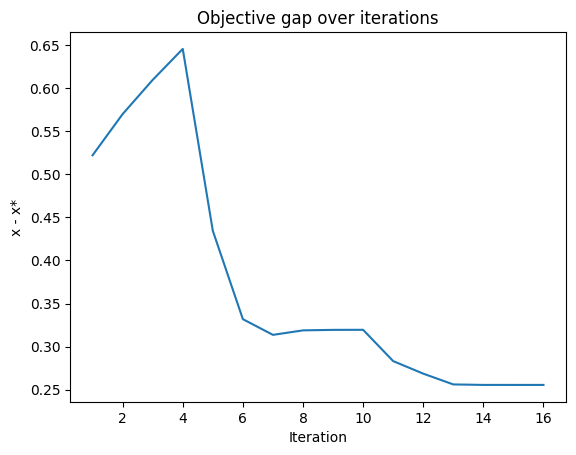

In [33]:
import matplotlib.pyplot as plt

m_data = m._data
# Extract time and objective values
times = [x[0] for x in m_data]
objs = [x[1] for x in m_data]

# Assuming x* is the final objective value
x_star = objs[-1]

# Calculate x - x* for each iteration
gap = [x - x_star for x in objs]

# Iteration count
iterations = list(range(1, len(objs) + 1))

# Create the plot
plt.plot(iterations, objs)
plt.xlabel('Iteration')
plt.ylabel('x - x*')
plt.title('Objective gap over iterations')
plt.show()

In [34]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=gap , mode='lines+markers', name='Solution Values', line=dict(width=4)))
fig.update_layout(title='Objective gap over iterations',
    font=dict(family="Times New Roman", size=18),
    title_x=0.5,
    legend=dict(orientation="h", x=1, y=1.1, xanchor="right"),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray',zeroline=True),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

fig.write_image("images/it_gap.pdf")
fig.show()

In [35]:
for constr in m.getConstrs():
    print(constr.ConstrName, m.getRow(constr))

net_power_balance_1 -2425.356030138444 theta[1] + 2425.356030138444 theta[2] + dummy placeholder
net_power_balance_2 2425.356030138444 theta[1] + -2427.864605123127 theta[2] + 2.5085749846832197 theta[3] + dummy placeholder
net_power_balance_3 2.5085749846832197 theta[2] + -5.017149969366439 theta[3] + 2.5085749846832197 theta[4] + dummy placeholder
net_power_balance_4 2.5085749846832197 theta[3] + -5.14118745422658 theta[4] + 2.5085749846832197 theta[5] + 0.1240374848601413 theta[12] + dummy placeholder
net_power_balance_5 2.5085749846832197 theta[4] + -5.14118745422658 theta[5] + 2.5085749846832197 theta[6] + 0.1240374848601413 theta[13] + dummy placeholder
net_power_balance_6 2.5085749846832197 theta[5] + -5.017149969366439 theta[6] + 2.5085749846832197 theta[7] + dummy placeholder
net_power_balance_7 2.5085749846832197 theta[6] + -5.14118745422658 theta[7] + 2.5085749846832197 theta[8] + 0.1240374848601413 theta[17] + dummy placeholder
net_power_balance_8 2.5085749846832197 theta[7

In [36]:
import numpy as np
from scipy.sparse import dok_matrix

# model variables and constraints
n_vars = m.NumVars
n_constrs = m.NumConstrs

# Initialize A matrix as a sparse DOK matrix, B and C vectors with higher precision
A = dok_matrix((n_constrs, n_vars), dtype=np.float64)
b = np.zeros(n_constrs, dtype=np.float64)
c = np.zeros(n_vars, dtype=np.float64)

# Create mapping from variable name to index
var_dict = {var.VarName: index for index, var in enumerate(m.getVars())}

# Populate B vector and A matrix
for i, constr in enumerate(m.getConstrs()):
    b[i] = constr.RHS
    expr = m.getRow(constr)
    for j in range(expr.size()):
        var = expr.getVar(j)
        coeff = expr.getCoeff(j)
        var_index = var_dict[var.VarName]
        A[i, var_index] = coeff

# Populate C
for i, var in enumerate(m.getVars()):
    c[i] = var.Obj

# Convert A to a CSR matrix
A = A.tocsr()

In [37]:
A = A.toarray()
print("Shape of A:", A.shape)
print("Shape of b:", b.shape)
print("Shape of c:", c.shape)

Shape of A: (377, 94)
Shape of b: (377,)
Shape of c: (94,)


In [38]:
import numpy as np
from gurobipy import Model

num_constraints = len(m.getConstrs())
num_variables = m.NumVars
A = np.zeros((num_constraints, num_variables))


# dictionary to map coefficients to their (constraint, variable) pairs
coeff_map = {}

# Populate the matrix 'A' with coefficients
for i, constr in enumerate(m.getConstrs()):
    expr = m.getRow(constr)
    for j in range(expr.size()):
        var = expr.getVar(j)
        coeff = expr.getCoeff(j)
        var_index = var.index
        A[i, var_index] = coeff
        coeff_map[(i, var_index)] = (constr.ConstrName, var.VarName)

In [39]:
A

array([[    0.        , -2425.35603014,  2425.35603014, ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  2425.35603014, -2427.86460512, ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     2.50857498, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

In [40]:
# Initialize an empty vector to store the right-hand side constants
num_constraints = len(m.getConstrs())
b = np.zeros(num_constraints)

# dictionary to map elements of 'b' to their corresponding constraints
b_map = {}

# Populate the vector 'b' and the b_map
for i, constr in enumerate(m.getConstrs()):
    b[i] = constr.RHS
    b_map[i] = constr.ConstrName

In [41]:
b_map

{0: 'net_power_balance_1',
 1: 'net_power_balance_2',
 2: 'net_power_balance_3',
 3: 'net_power_balance_4',
 4: 'net_power_balance_5',
 5: 'net_power_balance_6',
 6: 'net_power_balance_7',
 7: 'net_power_balance_8',
 8: 'net_power_balance_9',
 9: 'net_power_balance_10',
 10: 'net_power_balance_11',
 11: 'net_power_balance_active_12_0',
 12: 'net_power_balance_12',
 13: 'net_power_balance_13',
 14: 'net_power_balance_14',
 15: 'net_power_balance_15',
 16: 'net_power_balance_inactive_16_0',
 17: 'net_power_balance_16',
 18: 'net_power_balance_active_17_1',
 19: 'net_power_balance_17',
 20: 'net_power_balance_inactive_18_1',
 21: 'net_power_balance_18',
 22: 'net_power_balance_active_19_2',
 23: 'net_power_balance_19',
 24: 'net_power_balance_20',
 25: 'net_power_balance_21',
 26: 'net_power_balance_inactive_22_2',
 27: 'net_power_balance_22',
 28: 'net_power_balance_23',
 29: 'net_power_balance_24',
 30: 'net_power_balance_25',
 31: 'net_power_balance_26',
 32: 'net_power_balance_27',
 3

In [42]:
def check_big_m_in_matrix(A, threshold=1e3):
    # Find the indices where the absolute value of coefficients in A is greater than the threshold
    big_m_indices = np.where(np.abs(A) > threshold)

    # Check if any such indices are found
    if big_m_indices[0].size > 0:
        return True, big_m_indices
    else:
        return False, None


In [43]:
is_big_m_used, big_m_indices = check_big_m_in_matrix(A)

if is_big_m_used:
    print("Big M method likely used. Large coefficients found at indices:", big_m_indices)
else:
    print("No evidence of Big M method based on the coefficient matrix.")


Big M method likely used. Large coefficients found at indices: (array([  0,   0,   1,   1,  11,  16,  18,  20,  22,  24,  24,  25,  25,
        26,  28,  28,  29,  29,  40,  42,  44,  48,  50,  52,  57,  57,
        58,  58,  61,  61,  62,  62, 201, 201, 202, 202, 205, 205, 206,
       206, 217, 217, 218, 218, 221, 221, 222, 222]), array([ 1,  2,  1,  2, 45, 45, 46, 46, 47, 20, 21, 20, 21, 47, 23, 24, 23,
       24, 48, 48, 49, 49, 50, 50,  1,  2,  1,  2,  1,  2,  1,  2, 20, 21,
       20, 21, 20, 21, 20, 21, 23, 24, 23, 24, 23, 24, 23, 24]))


In [44]:
import numpy as np

sgen_data = net.sgen
load_data = net.load

# Determine the number of buses based on the maximum bus number in either dataframe
n_buses = max(sgen_data['bus'].max(), load_data['bus'].max()) + 1

# Create empty matrices for generation and load with the same index and order
generation_matrix = np.zeros((n_buses, n_buses))
load_matrix = np.zeros((n_buses, n_buses))

# Populate the generation and load matrices based on dataframes
for _, row in sgen_data.iterrows():
    bus = row['bus']
    p_mw = row['p_mw']
    generation_matrix[bus][bus] += p_mw

for _, row in load_data.iterrows():
    bus = row['bus']
    p_mw = row['p_mw']
    load_matrix[bus][bus] += p_mw

# Print the generation matrix
print("Generation Matrix:")
print(generation_matrix)

# Print the load matrix
print("\nLoad Matrix:")
print(load_matrix)


Generation Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Load Matrix:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00120379 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.00120379]]


# Updating network state with validated $q_t$

In [45]:
for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
  executed_quantity = x[t].X  * quantity
  #Update generation at source bus
  net.sgen.loc[net.sgen['bus'] == source_bus, 'p_mw'] += executed_quantity

  # Update load at destination bus
  net.load.loc[net.load['bus'] == dest_bus, 'p_mw'] += executed_quantity

In [46]:
import pandapower as pp
pp.rundcpp(net) #DC

In [47]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.0,0.000000,-0.007223,NaN
1,1.0,0.000000,0.000000,NaN
2,1.0,-30.005518,0.000000,NaN
3,1.0,-30.006773,0.000000,NaN
4,1.0,-30.008028,0.000000,NaN
5,1.0,-30.077008,0.000000,NaN
6,1.0,-30.077008,0.000000,NaN
7,1.0,-30.077008,0.000000,NaN
8,1.0,-30.143477,0.000000,NaN
9,1.0,-30.209946,0.000000,NaN


In [48]:
!pip freeze > requirements.txt

In [49]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>